In [1]:
import os
import pandas as pd
import numpy as np
import glob

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_formatrmat = 'retina'

In [2]:
from stesml.data_tools import get_train_and_test_index
from stesml.data_tools import load_data_sulfur
from stesml.data_tools import series_to_supervised
from stesml.data_tools import get_train_data_sulfur
from stesml.data_tools import get_test_data_sulfur

from stesml.model_tools import get_model
from stesml.model_tools import walk_forward_validation
from stesml.model_tools import get_predictions
from stesml.model_tools import get_progress

from stesml.postprocessing_tools import get_h

from stesml.plot_tools import get_plot_data
from stesml.plot_tools import plot_test_results_sulfur
from stesml.plot_tools import plot_average_error_sulfur
from stesml.plot_tools import plot_progress_results

/Users/kmenear/Projects/envSulfurTES/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
data_dir = "../data/Sulfur_Models/"

scenario_index = pd.DataFrame({"filepath": glob.glob(os.path.join(data_dir, "ML_*_*.csv"))})

In [4]:
model_type = "RandomForest"
is_recurrent = True
n_estimators = 100
target = 'T'
per_case = True

In [5]:
from typing import Tuple

def relu(x):
    return max(x,0)

def focal_obj(X_train):
    def custom_obj(y: np.ndarray, y_hat: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        rows = y.shape[0]
        zeros = np.zeros((rows), dtype=float)
        ones = np.ones((rows), dtype=float)
        grad = np.zeros((rows), dtype=float)
        hess = np.zeros((rows), dtype=float)
        Tw = X_train[:,1]
        Ti = X_train[:,2]
        # (y_hat - y)^2 + relu(Ti-y_hat) + relu(y_hat - Tw)
        grad = 4*(y_hat - y) - 0*np.maximum((Ti - y_hat),zeros) + 0*np.maximum((y_hat - Tw),zeros)
        hess = 4*ones + 0*np.maximum(np.sign(Ti - y_hat),zeros) + 0*np.maximum(np.sign(y_hat - Tw),zeros)
        grad = grad.reshape((rows, 1))
        hess = hess.reshape((rows, 1))
        return grad, hess
    return custom_obj

In [6]:
train_index, test_index = get_train_and_test_index(scenario_index)

X_train, y_train = get_train_data_sulfur(scenario_index, train_index, test_index, is_recurrent, target=target, per_case=per_case)
X_test, y_test = get_test_data_sulfur(scenario_index, test_index, is_recurrent, target=target)

/Users/kmenear/Projects/envSulfurTES/lib/python3.9/site-packages/stesml-0+unknown-py3.9.egg/stesml/data_tools.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [7]:
#train_df = load_data_sulfur(scenario_index, train_index)
#train = train_df[["flow-time", "Tw", "Ti", "Tavg", "Tx"]].to_numpy()
#train_shift = pd.DataFrame(series_to_supervised(train))
# Get rid of last prediction for each set, 
# because the next datapoint is the first datapoint of the next set
#train_shift.drop(abs(train_shift[train_shift[0] == 0].index - 1), inplace = True)
#train_shift.drop(train_shift[train_shift[0] < 0.2].index, inplace = True)
#train_shift = train_shift.to_numpy()

In [8]:
#print(abs(train_shift[train_shift[0] == 0].index - 1))

In [9]:
#print(train_shift[train_shift[0] < 0.2].index)

In [10]:
#print(train_shift)

In [11]:
#train_shift[train_shift[0] == 21.15].index

In [12]:
model = get_model(model_type, n_estimators)

In [13]:
#from xgboost import XGBRegressor
#model = XGBRegressor(n_estimators=n_estimators, colsample_bylevel=.75, objective=focal_obj(X_train))

In [14]:
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=30)

In [ ]:
y_hat = get_predictions(model, X_test, is_recurrent)

In [11]:
print(r2_score(y_test, y_hat))

0.9786396155811125


In [12]:
print(mean_squared_error(y_test, y_hat, squared=False))

6.840455034355428


In [13]:
#test_df = load_data(scenario_index, test_index, is_recurrent_test_data=True, is_train_data=False)
#h = get_h(test_df[5])

In [14]:
#import matplotlib.pyplot as plt
#window = 25
#average_h = []
#for ind in range(len(h) - window + 1):
#    average_h.append(np.mean(h[ind:ind+window]))
    
#plt.plot(h)

In [13]:
test_df = load_data_sulfur(scenario_index, test_index)
test_df_plot = get_plot_data(y_hat, test_df, test_index, is_recurrent)

In [14]:
#plot_average_error_sulfur(test_df_plot)

<AxesSubplot:>

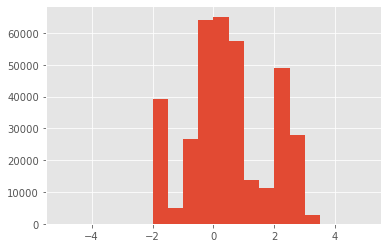

In [15]:
(100*(test_df_plot["Tavg"] - test_df_plot["Tc_hat"])/test_df_plot["Tavg"]).hist(bins=20, range=(-5, 5))

<AxesSubplot:>

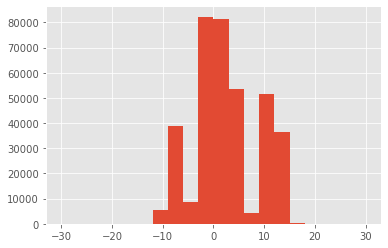

In [16]:
(test_df_plot["Tavg"] - test_df_plot["Tc_hat"]).hist(bins=20, range=(-30, 30))

In [17]:
#plot_error_vs_T(test_df_plot)

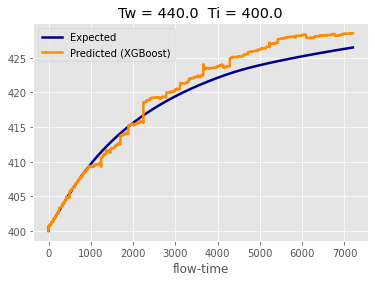

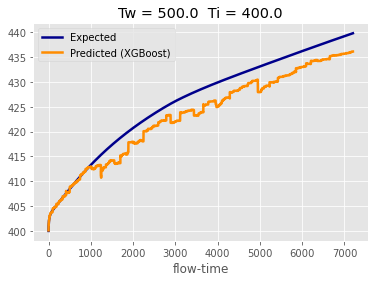

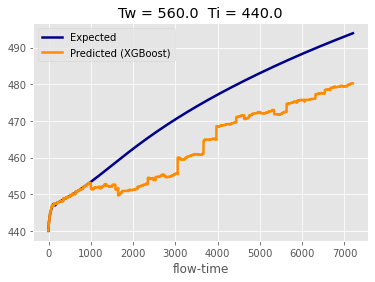

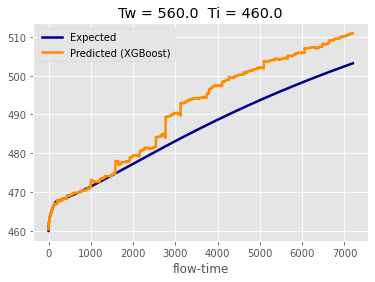

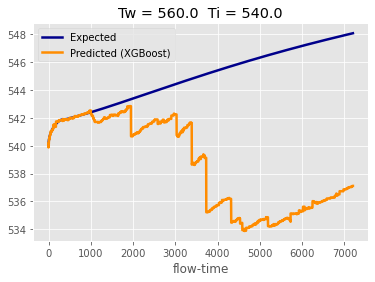

In [18]:
plot_test_results_sulfur(test_df_plot, model_type, target=target)

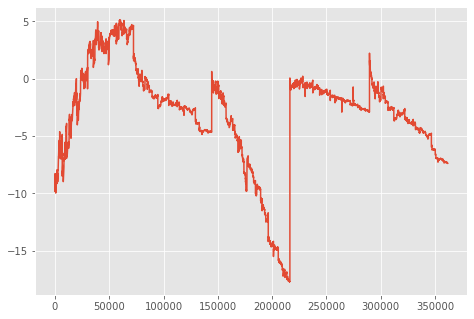

In [21]:
import matplotlib.pyplot as plt
ax = plt.figure().add_axes([0,0,1,1])
ax.plot(y_test-y_hat)
#ax.set_yscale('log')
plt.show()

In [19]:
min_estimators = 100
max_estimators = 101
step_size = 2
num_shuffle_iterations = 10

rmse_history, r2_history = get_progress(model_type, scenario_index, min_estimators, max_estimators, step_size, num_shuffle_iterations, is_recurrent, verbose=True, target=target, per_case=per_case)

0
Predicted: [400.1585  400.1585  400.1585  ... 430.30524 430.30524 430.30524]
Expected: [399.99999977 400.00017721 400.00035444 ... 429.38443891 429.38458155
 429.38471751]
1
Predicted: [439.91254 439.91254 439.91254 ... 454.69876 454.69876 454.69876]
Expected: [439.99999974 440.00013131 440.00026308 ... 440.87735511 440.87752571
 440.87768191]
2
Predicted: [400.19287 400.19287 400.19287 ... 526.71704 526.71704 526.71704]
Expected: [399.99999977 400.00025574 400.00051137 ... 552.21369833 552.2141174
 552.21450086]
3
Predicted: [520.12384 520.12384 520.12384 ... 469.5214  469.5214  469.5214 ]
Expected: [519.9999997  520.00005904 520.00011833 ... 490.90945642 490.91011916
 490.91041926]
4
Predicted: [400.0334  400.0334  400.0334  ... 431.38013 431.38013 431.38013]
Expected: [399.99999977 400.00002467 400.00004954 ... 429.38443891 429.38458155
 429.38471751]
5
Predicted: [400.02844 400.02844 400.02844 ... 458.2847  458.2847  458.2847 ]
Expected: [399.99999977 400.00017721 400.00035444 ..

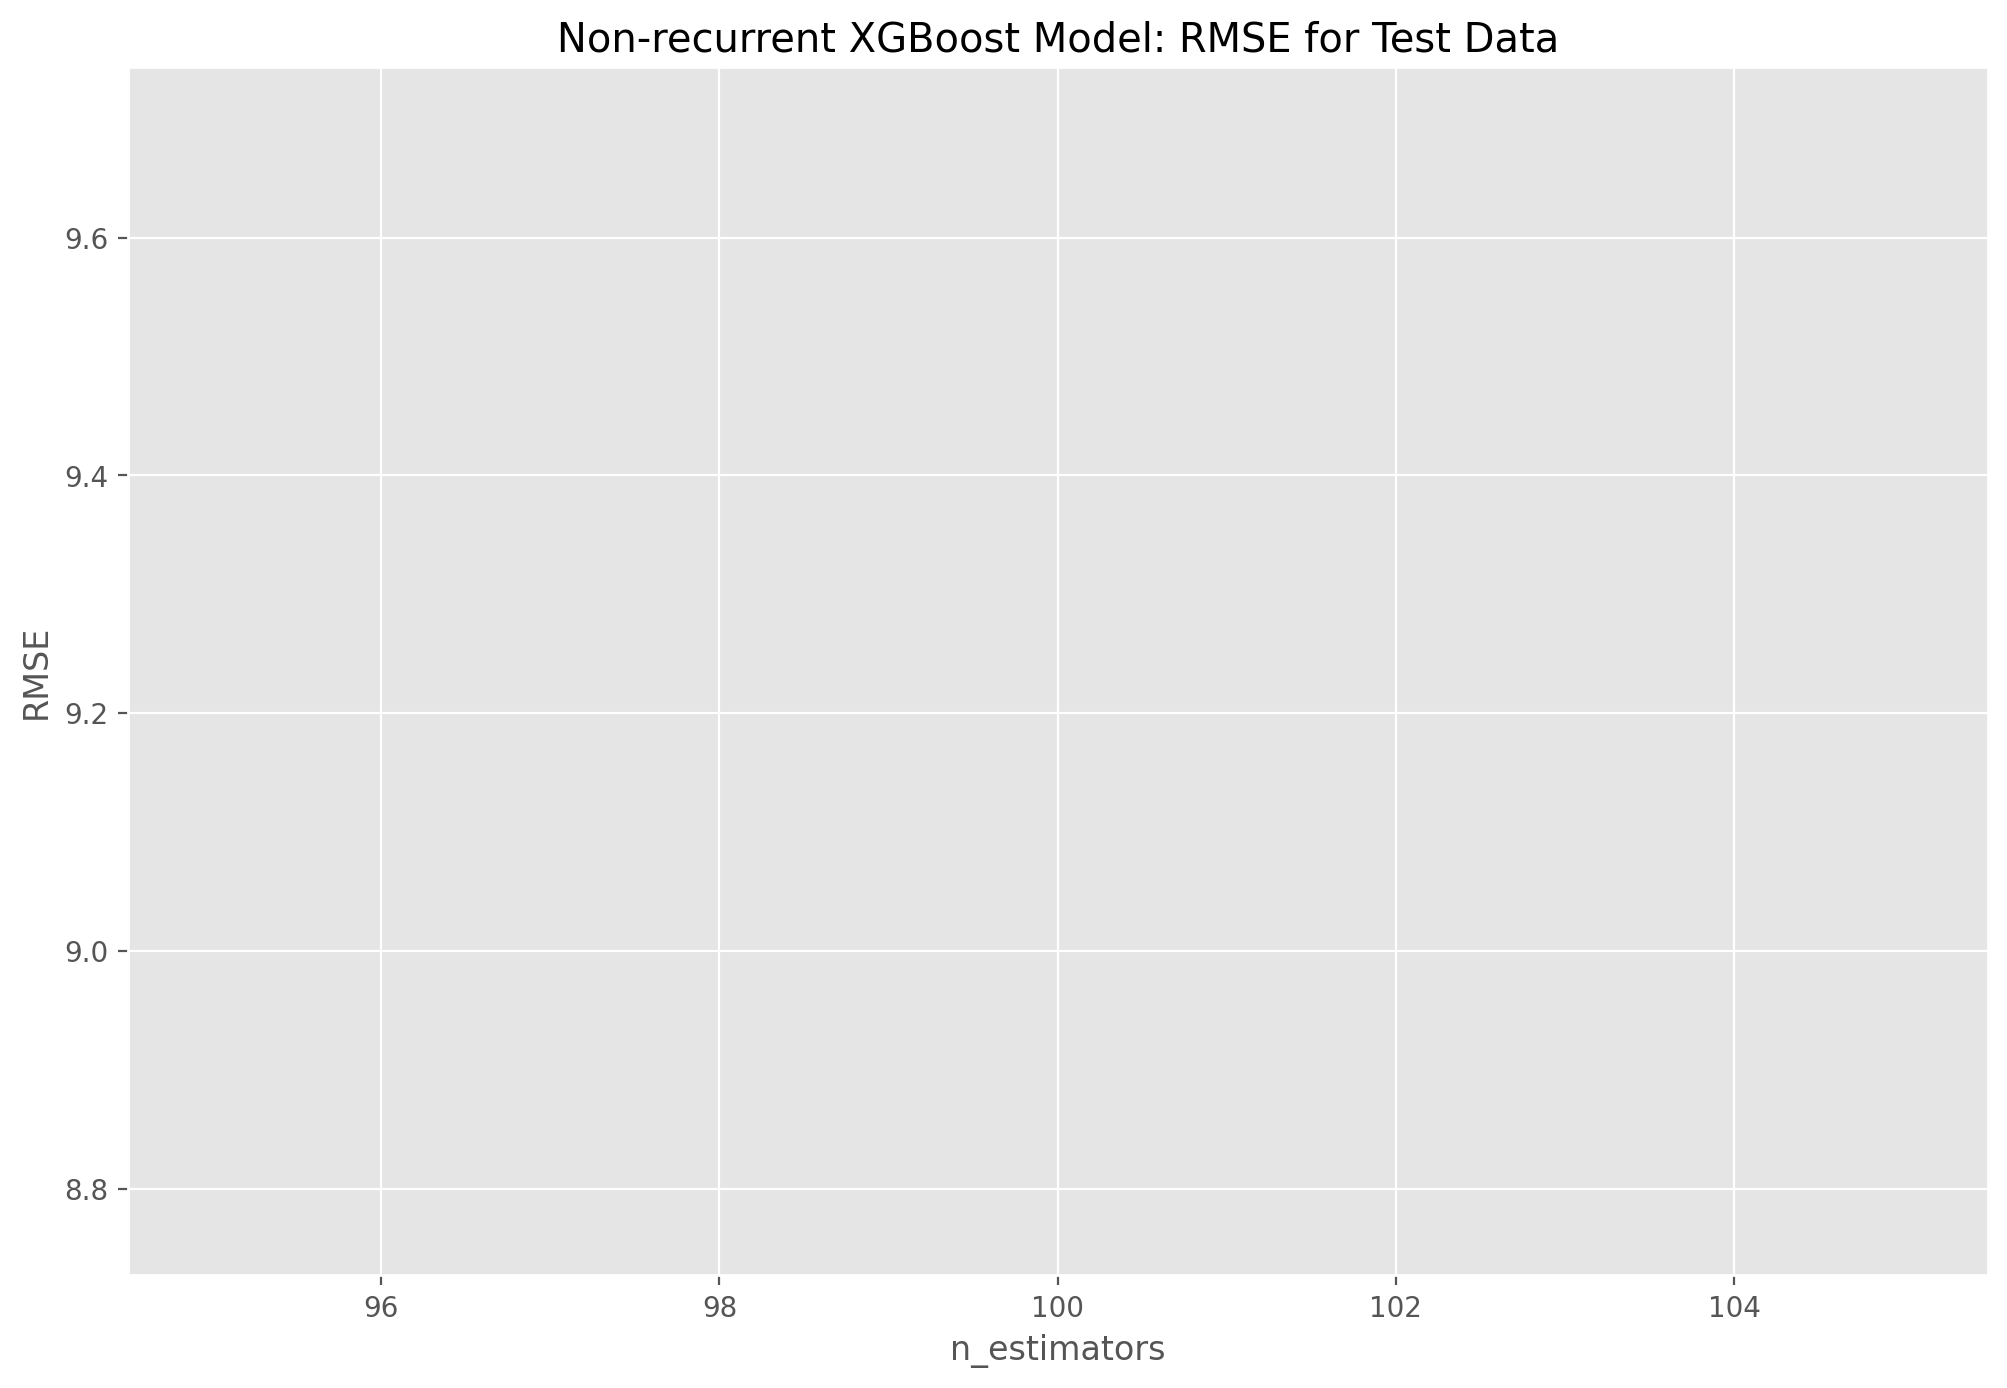

In [6]:
plot_progress_results(rmse_history, model_type, is_recurrent, metric="RMSE")

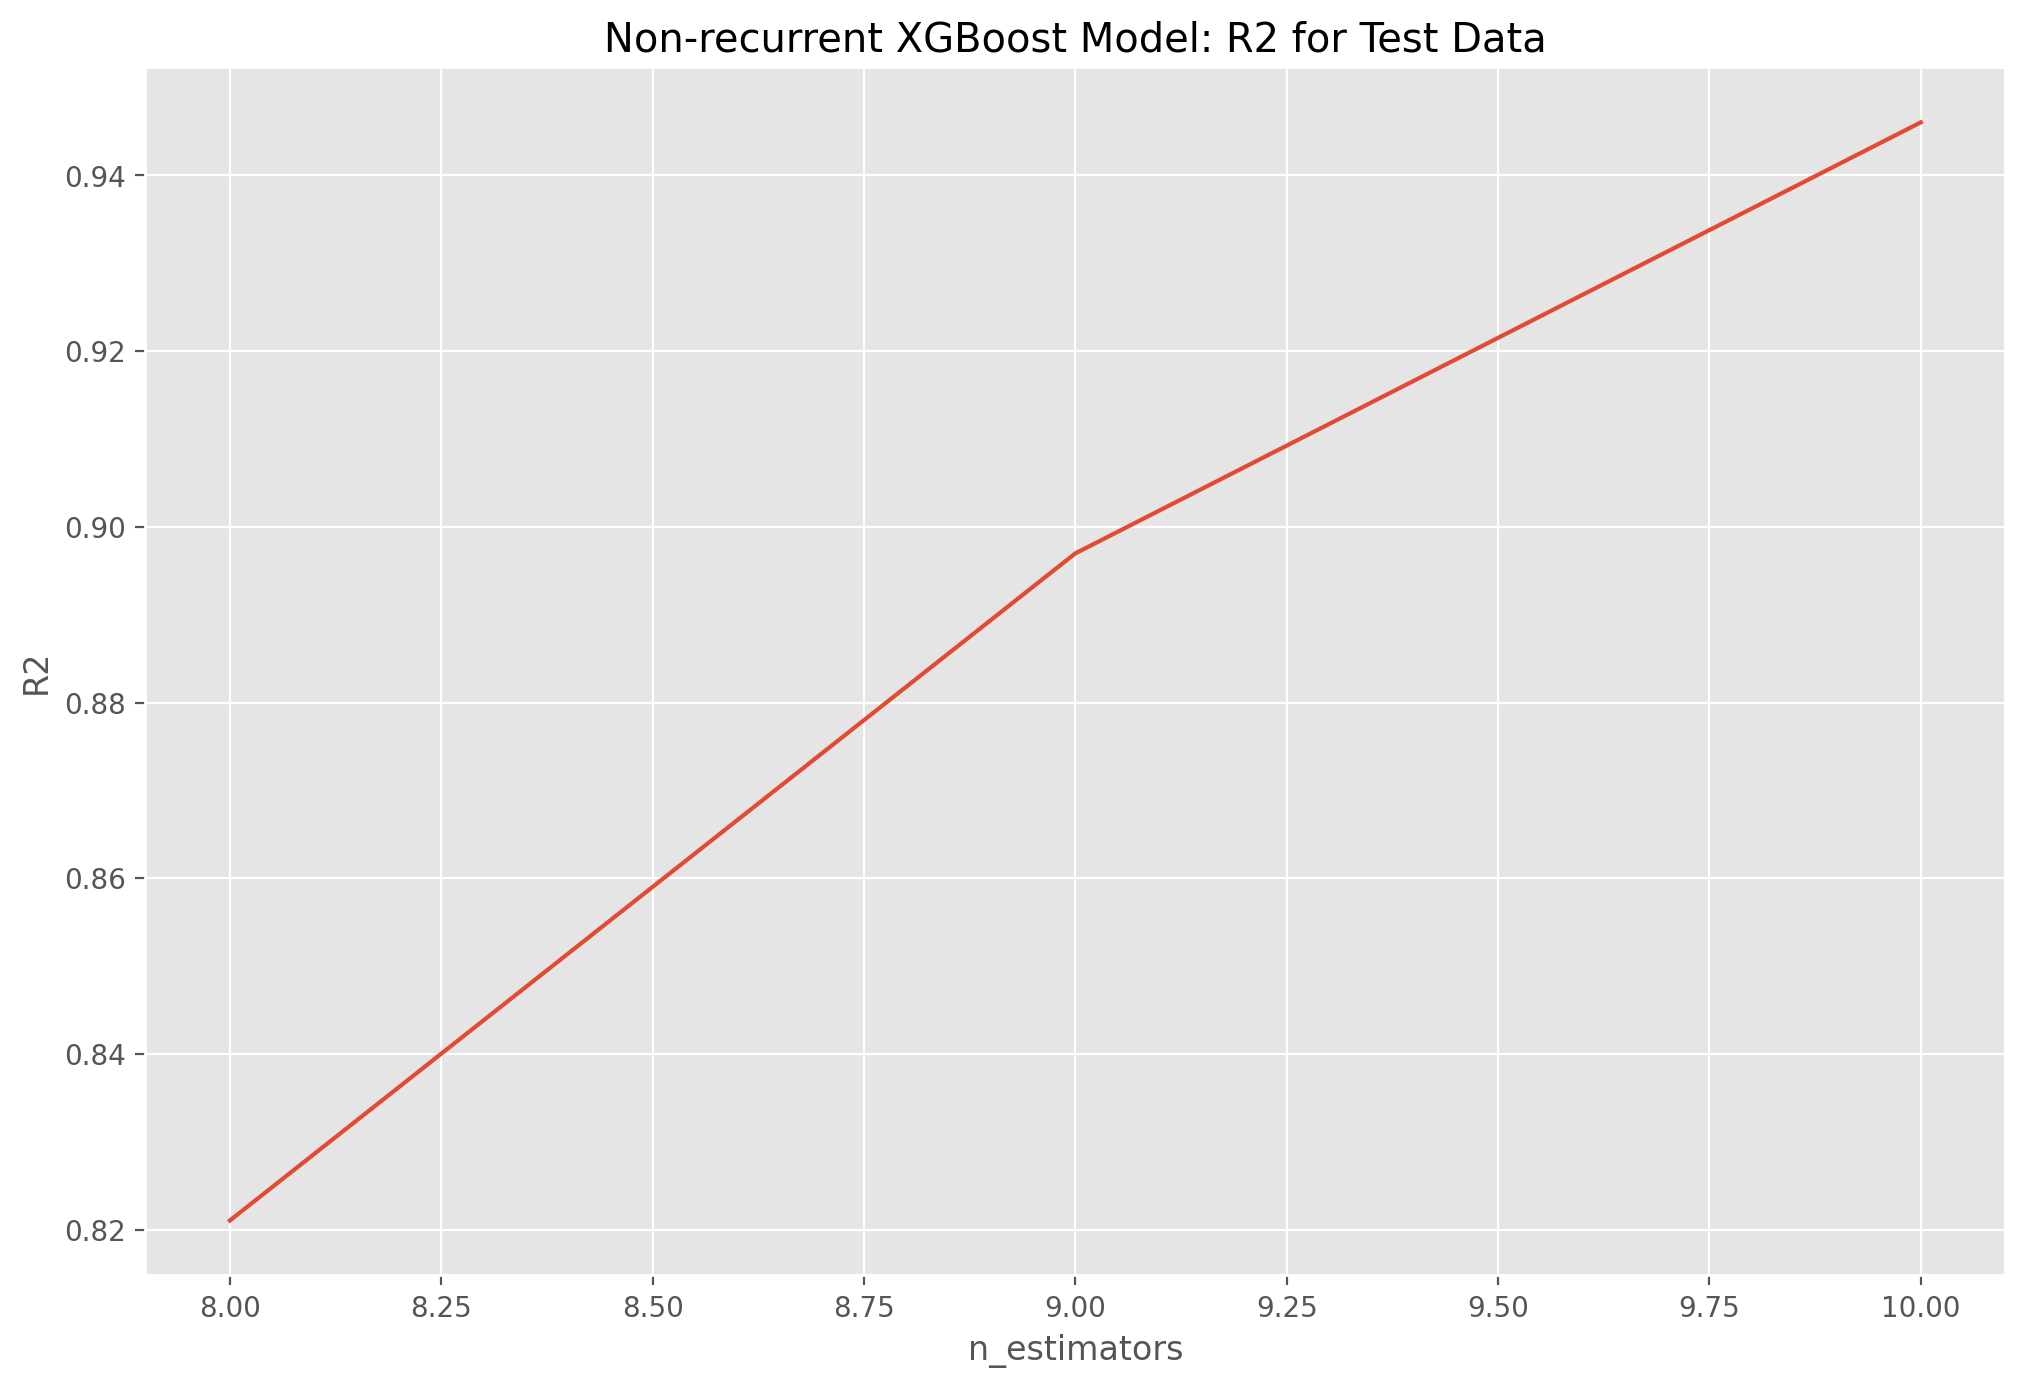

In [22]:
plot_progress_results(r2_history, model_type, is_recurrent, metric="R2")